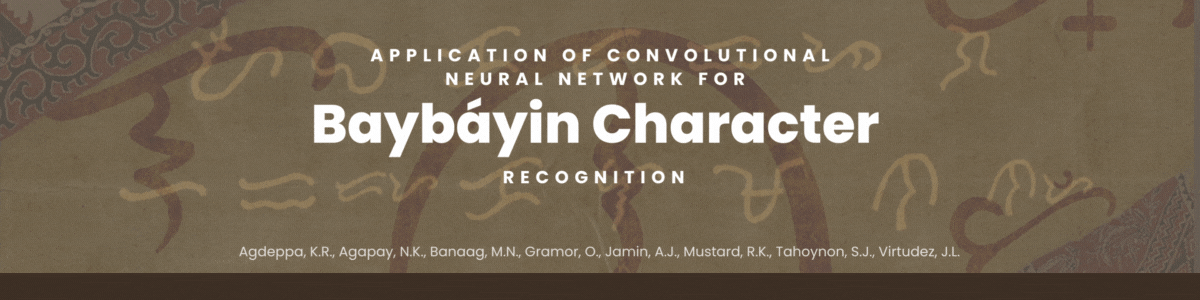

In [1]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download jamesnogra/baybayn-baybayin-handwritten-images

!unzip baybayn-baybayin-handwritten-images.zip -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/ng.Rlp5-Nino.jpg  
  inflating: dataset/ng.SCnc-James.jpg  
  inflating: dataset/ng.T1pW-James.jpg  
  inflating: dataset/ng.T2IC-James.jpg  
  inflating: dataset/ng.TD6E-Nino.jpg  
  inflating: dataset/ng.TSUX-James.jpg  
  inflating: dataset/ng.TUXx-James.jpg  
  inflating: dataset/ng.Tdg3-James.jpg  
  inflating: dataset/ng.TfDv-John.jpg  
  inflating: dataset/ng.Th2r-Nino.jpg  
  inflating: dataset/ng.TliN-James.jpg  
  inflating: dataset/ng.U2bd-James.jpg  
  inflating: dataset/ng.UNG0-John.jpg  
  inflating: dataset/ng.UYe8-John.jpg  
  inflating: dataset/ng.Uvdi-Nino.jpg  
  inflating: dataset/ng.V0kZ-James.jpg  
  inflating: dataset/ng.V6Wn-Nino.jpg  
  inflating: dataset/ng.VJa6-John.jpg  
  inflating: dataset/ng.VfIc-James.jpg  
  inflating: dataset/ng.Vt1J-James.jpg  
  inflating: dataset/ng.VurW-James.jpg  
  inflating: dataset/ng.VxbK-James.jpg  
  inflating: dataset/ng.X9g9-Nino.jpg  
  inflating: dat

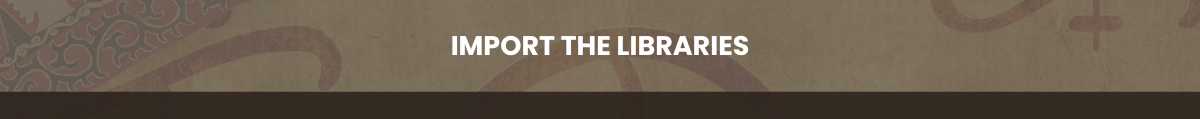

In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from PIL import Image
import torch
from torchvision import transforms
import torch.nn as nn

import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

import optuna

import warnings
warnings.filterwarnings("ignore")

In [4]:
# set the seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(42)

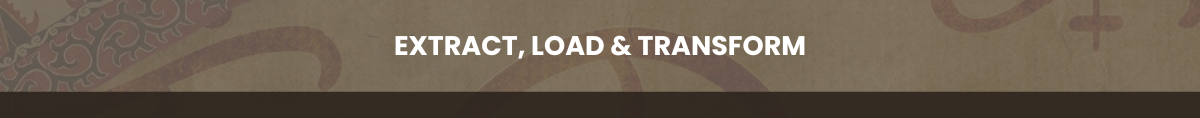

In [5]:
# extracting the image path and their corresponding labels
IMAGE_FILES_LIST = []
IMAGE_LABELS_LIST = []

for dirname, _, filenames in os.walk('dataset'):
    for filename in filenames:
        IMAGE_LABELS_LIST.append(filename.split(".")[0])
        IMAGE_FILES_LIST.append(os.path.join(dirname, filename))

In [6]:
class ImageDataset(Dataset):
    """
        Loads all the images, converts it to grayscale and transforms it into tensor.
        
        Attributes
        -------------
        image_files: list or tuple
            a list of strings that contains the path to the images
        
        image_labels: list or tuple
            a list of strings that contains the labels relative to the images

        transform: function, default = None
            A transform to apply to the images.
    """
    def __init__(self, image_files, image_labels, transform=None):

        self.image_labels = image_labels
        self.image_files = image_files
        self.transform = transform

    def __len__(self):
        """
            Returns the number of images in the dataset.
        """
        return len(self.image_files)

    def __getitem__(self, idx):
        """
            Returns the image and any associated label (if applicable) at the specified index.
        """

        image_path = self.image_files[idx]
        image_label = self.image_labels[idx]

        image = Image.open(image_path).convert('L')

        if self.transform:
            X = self.transform(image)

        return (X, image_label)

In [7]:

UNIQUE_LABELS_ARR = np.unique(IMAGE_LABELS_LIST)

LABELS_MAPPING_REFERENCE = {label:idx for idx, label in enumerate(UNIQUE_LABELS_ARR)}

TRANSFORMED_LABELS_LIST = [LABELS_MAPPING_REFERENCE[labels] for labels in IMAGE_LABELS_LIST]

In [8]:
# transformation
TRANSFORM = transforms.Compose([transforms.ToTensor()])

IMAGE_DATASET = ImageDataset(image_files=IMAGE_FILES_LIST,
                            image_labels=TRANSFORMED_LABELS_LIST,
                            transform=TRANSFORM)

# 0,6/0,2/0.2 SPLIT RATIO
train_set, val_set, test_set = torch.utils.data.random_split(IMAGE_DATASET, [0.6, 0.2, 0.2])

In [9]:
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [11]:
TENSOR_IMAGES, LABELS = iter(val_loader).__next__()

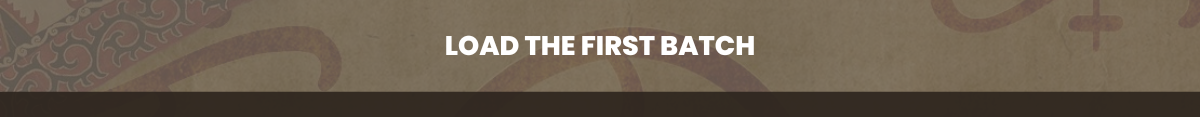

In [10]:
def display_image(batch, if_rgb=True):
    """
        Displays all the images in a batch, in rgb format or grayscale.

        Parameters
        -------------
        batch: torch.Tensor
            the tensor representation of the images inside the batch
        
        if_rgb: bool, default = True
            if True then tensor will be transposed and converted into numpy for rgb, else, show the images without transposing

        Returns
        -------------
        None
    
    """
    batch = batch.detach().numpy()
    _, axs = plt.subplots(1, len(batch), figsize=(35, 25))

    if if_rgb:

        for i in range(len(batch)):
            image = np.transpose(TENSOR_IMAGES[i].numpy(), (1, 2, 0))

            axs[i].imshow(image)
            axs[i].axis('off')
            axs[i].set_title(LABELS[i].item())
    else:
        for i in range(len(batch)):
            axs[i].imshow(batch[i, 0, :, :], vmin=0, vmax=1)
            axs[i].axis('off')
            axs[i].set_title(LABELS[i].item())

    plt.show()

torch.Size([32, 1, 28, 28])


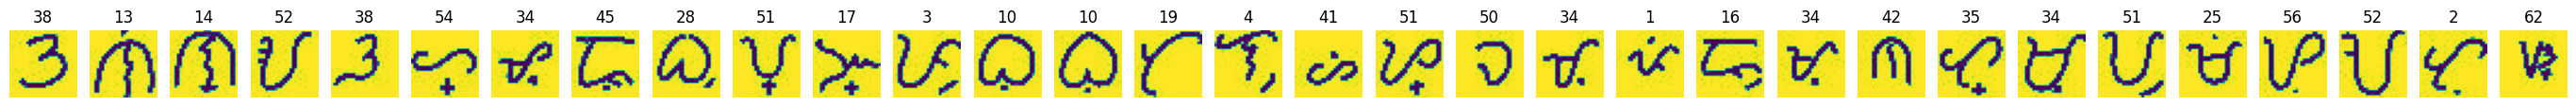

In [18]:
print(TENSOR_IMAGES.size())

display_image(TENSOR_IMAGES, False)

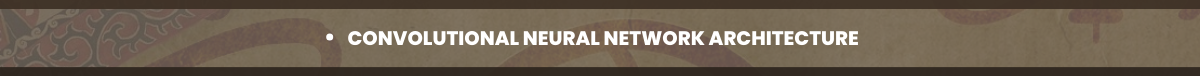

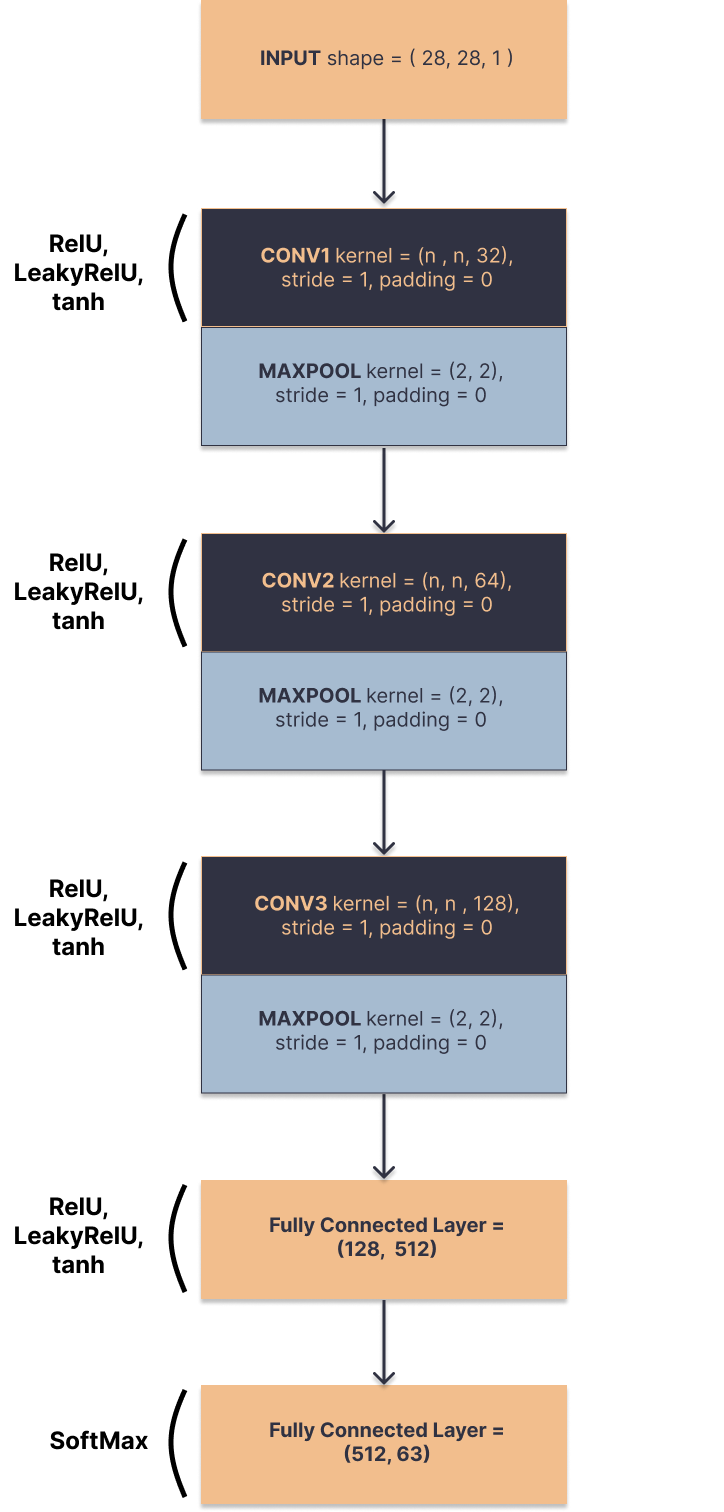

In [13]:
class ConvolutionalNeuralNetwork(nn.Module):
    """
        Convolutional Neural Network (CNN) for image classification.

        Parameters
        ----------
        conv_filter_size : tuple
            The size of the convolution filter.
        activation_function : function
            The activation function to be applied after each convolutional layer.
        final_size : int
            The final size of the image after the 3 convolutions and maxpooling

        Attributes
        ----------
        conv1 : nn.Conv2d
            First convolutional layer with 32 output channels.
        pool1 : nn.MaxPool2d
            First max-pooling layer.
        conv2 : nn.Conv2d
            Second convolutional layer with 64 output channels.
        pool2 : nn.MaxPool2d
            Second max-pooling layer.
        conv3 : nn.Conv2d
            Third convolutional layer with 128 output channels.
        pool3 : nn.MaxPool2d
            Third max-pooling layer.
        fcn1 : nn.Linear
            First fully connected layer with 512 output features.
        fcn2 : nn.Linear
            Second fully connected layer with 63 output features.

        Methods
        -------
        forward(x)
            Forward pass through the CNN.

        Examples
        --------
        >>> import torch
        >>> import torch.nn as nn
        >>> import torch.nn.functional as F
        >>>
        >>> # Create an instance of ConvolutionalNeuralNetwork
        >>> cnn = ConvolutionalNeuralNetwork((3, 3), F.relu, 8)
        >>>
        >>> # Perform a forward pass with dummy input
        >>> input_data = torch.randn(1, 1, 28, 28)  # (batch size, channels, height, width)
        >>> output = cnn(input_data)
    """

    def __init__(self, conv_filter_size, activation_function, final_size):
        super().__init()

        self.conv_filter_size = conv_filter_size
        self.activation_function = activation_function
        self.final_size = final_size

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=32,
                               kernel_size=self.conv_filter_size,
                               stride=1,
                               padding=0)

        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2),
                                  stride=1)

        self.conv2 = nn.Conv2d(in_channels=32,
                               out_channels=64,
                               kernel_size=self.conv_filter_size,
                               stride=1,
                               padding=0)

        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2),
                                  stride=1)

        self.conv3 = nn.Conv2d(in_channels=64,
                               out_channels=128,
                               kernel_size=self.conv_filter_size,
                               stride=1,
                               padding=0)

        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2),
                                  stride=1)

        # Fully connected layers
        self.fcn1 = nn.Linear(128 * self.final_size * self.final_size, 512)
        self.fcn2 = nn.Linear(512, 63)

    def forward(self, x):
        x = self.activation_function(self.conv1(x))
        x = self.pool1(x)

        x = self.activation_function(self.conv2(x))
        x = self.pool2(x)

        x = self.activation_function(self.conv3(x))
        x = self.pool3(x)

        x = x.view(-1, 128 * self.final_size * self.final_size)

        x = self.activation_function(self.fcn1(x))

        x = F.softmax(self.fcn2(x), dim=1)

        return x

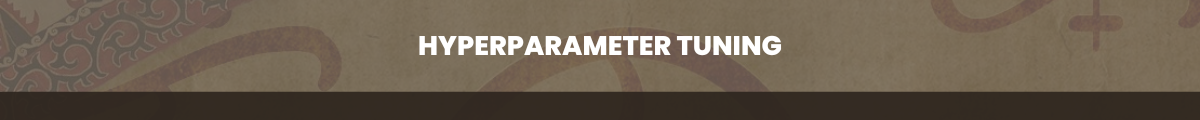

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [15]:
def tune_CNN(trial, train_loader_, val_loader_):
    """
      Tune a Convolutional Neural Network (CNN) using various hyperparameters.

      Parameters
      ----------
      trial : optuna.Trial
          An Optuna trial object used for hyperparameter optimization.

      train_loader_ : torch.utils.data.DataLoader
          DataLoader for the training dataset.

      val_loader_ : torch.utils.data.DataLoader
          DataLoader for the validation dataset.

      Returns
      -------
      float
          The accuracy of the tuned CNN model on the validation dataset.

      Notes
      -----
      This function performs hyperparameter optimization for a CNN model using the Optuna library.

      The hyperparameters that can be optimized are:
      - Kernel size for convolutional layers
      - Choice of optimizer (SGD, Adam, or RMSprop)
      - Activation functions (ReLU, Leaky ReLU, or Tanh)
      - Learning rate
      - Number of training epochs

      The CNN model is trained and tuned using the specified hyperparameters, and its accuracy on the
      validation dataset is returned.

      Examples
      --------
      >>> import optuna
      >>> study = optuna.create_study(direction='maximize')
      >>> study.optimize(tune_CNN, n_trials=10, args=(train_loader, val_loader))
      >>> best_trial = study.best_trial
      >>> best_accuracy = best_trial.value
      >>> best_params = best_trial.params
      >>> print(f"Best accuracy: {best_accuracy}")
      >>> print(f"Best hyperparameters: {best_params}")
    """
    kernel_size = trial.suggest_categorical("kernel size", [(3, 3), (5, 5), (7, 7)])
    optimizers_ = trial.suggest_categorical("optimizer", ["SGD", "Adam", "RMSprop"])
    activation_functions = trial.suggest_categorical("activation function", [F.relu, F.leaky_relu, F.tanh])
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)

    epochs = trial.suggest_int("epochs", 10, 50)

    _ORIGINAL_SIZE = 28
    _PADDING = 0
    _STRIDE = 1
    _MAX_POOL_SIZE = 2

    _NUM_OF_CONV = 3

    for _ in range(_NUM_OF_CONV):
        new_size = (_ORIGINAL_SIZE - kernel_size[0] + 2 * _PADDING) // _STRIDE + 1
        new_size = (new_size - _MAX_POOL_SIZE) // _STRIDE + 1

    CNN_model = ConvolutionalNeuralNetwork(kernel_size, activation_functions, new_size)

    CNN_model = CNN_model.to("cuda")

    criterion = nn.CrossEntropyLoss()

    if optimizers_ == "SGD":
        optimizer = optim.SGD(CNN_model.parameters(), lr=learning_rate)
    elif optimizers_ == "Adam":
        optimizer = optim.Adam(CNN_model.parameters(), lr=learning_rate)
    elif optimizers_ == "RMSprop":
        optimizer = optim.RMSprop(CNN_model.parameters(), lr=learning_rate)

    for _ in range(epochs):
        running_loss = 0.0

        for x_train, y_train in train_loader_:
            x_train = x_train.to("cuda")
            y_train = y_train.to("cuda")

            optimizer.zero_grad()
            outputs = CNN_model(x_train)

            loss = criterion(outputs, y_train)
            loss.backward()

            optimizer.step()
            running_loss += loss.item()

    correct = 0
    total = 0
    with torch.no_grad():
        for val_X, val_y in val_loader_:
            val_X = val_X.to("cuda")
            val_y = val_y.to("cuda")

            outputs = CNN_model(val_X)

            _, predicted = torch.max(outputs.data, 1)
            total += val_y.size(0)

            correct += (predicted == val_y).sum().item()
    accuracy = correct / total

    torch.cuda.empty_cache()

    return accuracy

In [16]:
study = optuna.create_study(direction="maximize")

params = {"train_loader_":train_loader,
         "val_loader_":val_loader}

study.optimize(lambda trial: tune_CNN(trial, **params), n_trials=80, n_jobs=-1, show_progress_bar=True)

[I 2023-10-20 15:00:12,140] A new study created in memory with name: no-name-5df474a6-fb3d-421c-8cf4-987b0d5c0bc1


  0%|          | 0/80 [00:00<?, ?it/s]

[I 2023-10-20 15:02:08,210] Trial 0 finished with value: 0.017267648552564754 and parameters: {'kernel size': (5, 5), 'optimizer': 'Adam', 'activation function': <function relu at 0x794a90e6af80>, 'learning_rate': 0.003993125174947566, 'epochs': 14}. Best is trial 0 with value: 0.017267648552564754.
[I 2023-10-20 15:03:51,529] Trial 1 finished with value: 0.010665312341289994 and parameters: {'kernel size': (3, 3), 'optimizer': 'SGD', 'activation function': <function leaky_relu at 0x794a90e6b370>, 'learning_rate': 0.0011541480148034293, 'epochs': 32}. Best is trial 0 with value: 0.017267648552564754.
[I 2023-10-20 15:07:42,604] Trial 2 finished with value: 0.016251904520060943 and parameters: {'kernel size': (5, 5), 'optimizer': 'RMSprop', 'activation function': <function relu at 0x794a90e6af80>, 'learning_rate': 0.0030403680800070837, 'epochs': 49}. Best is trial 0 with value: 0.017267648552564754.
[I 2023-10-20 15:08:27,120] Trial 3 finished with value: 0.01218892839004571 and parame

In [17]:
study.best_params

{'kernel size': (7, 7),
 'optimizer': 'Adam',
 'activation function': <function torch.nn.functional.tanh(input)>,
 'learning_rate': 0.00022470591373363572,
 'epochs': 47}